In [146]:
"""
Data Sources:
    http://data.worldbank.org/indicator/SP.DYN.TFRT.IN?view=map&year=1960
    http://data.worldbank.org/indicator/SE.ADT.LITR.ZS?end=2010&start=1990&view=map&year=1990
    http://data.worldbank.org/indicator/NY.GDP.PCAP.CD?view=map
    http://data.worldbank.org/indicator/NY.GNP.PCAP.CD?view=map&year=2015
    http://data.worldbank.org/indicator/SP.DYN.LE00.IN?end=2014&start=2014&view=map&year=2014
    https://data.oecd.org/healthstat/suicide-rates.htm
    
"""
%matplotlib inline

from IPython.core.pylabtools import figsize
figsize(15,9)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import feature_extraction as skfe
from sklearn import ensemble as sken
from sklearn import linear_model as sklin

import copy

import os

In [147]:
data_dir = 'data/'

for f in sorted(os.listdir(data_dir)):
    print(f)

fert_file = data_dir + 'fertility_per_woman_by_country.csv'
gdp_file = data_dir + 'gdp_per_capita_by_country.csv'
gni_file = data_dir + 'gni_per_capita_by_country.csv'
life_file = data_dir + 'life_expectancy_by_country.csv'
lit_file = data_dir + 'literacy_by_country.csv'

suicide_file = data_dir + 'suicide_per_100k_by_country.csv'

.~lock.gdp_per_capita_by_country.csv#
.~lock.suicide_per_100k_by_country.csv#
fertility_per_woman_by_country.csv
gdp_per_capita_by_country.csv
gni_per_capita_by_country.csv
life_expectancy_by_country.csv
literacy_by_country.csv
suicide_per_100k_by_country.csv


In [148]:
frt_df = pd.read_csv(fert_file)
gdp_df = pd.read_csv(gdp_file)
gni_df = pd.read_csv(gni_file)
lex_df = pd.read_csv(life_file)
lit_df = pd.read_csv(lit_file)

scd_df = pd.read_csv(suicide_file)

In [160]:
def is_num(x):
    try:
        float(x)
        return True
    except:
        return False


def get_data(df, field, data_dict):
    for index, row in df.iterrows():
        country = row['Country Name']
        cc = row['Country Code']
        
        if cc not in data_dict:
            data_dict[cc] = {}
        
        for k in list(row.keys()):
            if is_num(k):
                str_k = str(k)
                if str_k not in data_dict[cc]:
                    data_dict[cc][str_k] = {}
                                    
                data_dict[cc][str_k][field] = row[k]

In [161]:
data_dict = {}
get_data(frt_df, 'fert', data_dict)
get_data(gdp_df, 'gdp',  data_dict)
get_data(gni_df, 'gni',  data_dict)
get_data(lex_df, 'lex',  data_dict)
get_data(lit_df, 'lit',  data_dict)

In [162]:
print(scd_df)

     LOCATION INDICATOR SUBJECT    MEASURE FREQUENCY  TIME  Value Flag Codes
0         AUS   SUICIDE     TOT  100000PER         A  1960   13.1        NaN
1         AUS   SUICIDE     TOT  100000PER         A  1961   14.5        NaN
2         AUS   SUICIDE     TOT  100000PER         A  1962   16.9        NaN
3         AUS   SUICIDE     TOT  100000PER         A  1963   19.2        NaN
4         AUS   SUICIDE     TOT  100000PER         A  1964   17.8        NaN
5         AUS   SUICIDE     TOT  100000PER         A  1965   18.0        NaN
6         AUS   SUICIDE     TOT  100000PER         A  1966   17.4        NaN
7         AUS   SUICIDE     TOT  100000PER         A  1967   18.4        NaN
8         AUS   SUICIDE     TOT  100000PER         A  1968   15.6          B
9         AUS   SUICIDE     TOT  100000PER         A  1969   14.9        NaN
10        AUS   SUICIDE     TOT  100000PER         A  1970   15.0        NaN
11        AUS   SUICIDE     TOT  100000PER         A  1971   16.3        NaN

In [163]:
target_name = 'TOT'

for index, row in scd_df.iterrows():
    cc = row['LOCATION']
    yr = str(row['TIME'])
    scd = row['Value']
    subj = row['SUBJECT']
    
    if cc not in data_dict:
        data_dict[cc] = {}
    
    if yr not in data_dict[cc]:
        data_dict[cc][yr] = {}
    
    if subj == target_name:
        data_dict[cc][yr]['TARGET'] = scd
        
print(data_dict['LVA'][2007])

KeyError: 2007

In [164]:
for cc in sorted(list(data_dict.keys())):
    print(cc)

ABW
AFG
AGO
ALB
AND
ARB
ARE
ARG
ARM
ASM
ATG
AUS
AUT
AZE
BDI
BEL
BEN
BFA
BGD
BGR
BHR
BHS
BIH
BLR
BLZ
BMU
BOL
BRA
BRB
BRN
BTN
BWA
CAF
CAN
CEB
CHE
CHI
CHL
CHN
CIV
CMR
COD
COG
COL
COM
CPV
CRI
CSS
CUB
CUW
CYM
CYP
CZE
DEU
DJI
DMA
DNK
DOM
DZA
EAP
EAR
EAS
ECA
ECS
ECU
EGY
EMU
ERI
ESP
EST
ETH
EUU
FCS
FIN
FJI
FRA
FRO
FSM
GAB
GBR
GEO
GHA
GIB
GIN
GMB
GNB
GNQ
GRC
GRD
GRL
GTM
GUM
GUY
HIC
HKG
HND
HPC
HRV
HTI
HUN
IBD
IBT
IDA
IDB
IDN
IDX
IMN
IND
INX
IRL
IRN
IRQ
ISL
ISR
ITA
JAM
JOR
JPN
KAZ
KEN
KGZ
KHM
KIR
KNA
KOR
KSV
KWT
LAC
LAO
LBN
LBR
LBY
LCA
LCN
LDC
LIC
LIE
LKA
LMC
LMY
LSO
LTE
LTU
LUX
LVA
MAC
MAF
MAR
MCO
MDA
MDG
MDV
MEA
MEX
MHL
MIC
MKD
MLI
MLT
MMR
MNA
MNE
MNG
MNP
MOZ
MRT
MUS
MWI
MYS
NAC
NAM
NCL
NER
NGA
NIC
NLD
NOR
NPL
NRU
NZL
OED
OMN
OSS
PAK
PAN
PER
PHL
PLW
PNG
POL
PRE
PRI
PRK
PRT
PRY
PSE
PSS
PST
PYF
QAT
ROU
RUS
RWA
SAS
SAU
SDN
SEN
SGP
SLB
SLE
SLV
SMR
SOM
SRB
SSA
SSD
SSF
SST
STP
SUR
SVK
SVN
SWE
SWZ
SXM
SYC
SYR
TCA
TCD
TEA
TEC
TGO
THA
TJK
TKM
TLA
TLS
TMN
TON
TSA
TSS
TTO
TUN
TUR
TUV
TZA
UGA
UKR
UMC
URY


In [170]:
input_dicts = []

for cc in data_dict:
    for yr in data_dict[cc]:
        row = copy.deepcopy(data_dict[cc][yr])
#         row['ctry'] = cc
        row['yr'] = int(yr)
        input_dicts.append(row)
        
print(list(filter(lambda x: 'TARGET' in x, input_dicts)))

[{'gni': nan, 'lit': nan, 'fert': 1.97, 'lex': 69.3282926829268, 'gdp': nan, 'yr': 1982, 'TARGET': 36.6}, {'gni': nan, 'lit': nan, 'fert': 2.11, 'lex': 70.6153658536585, 'gdp': nan, 'yr': 1988, 'TARGET': 24.5}, {'gni': nan, 'lit': nan, 'fert': 1.86, 'lex': 68.8085365853659, 'gdp': nan, 'yr': 1980, 'TARGET': 34.4}, {'gni': nan, 'lit': nan, 'fert': 1.73, 'lex': 68.3960975609756, 'gdp': nan, 'yr': 1992, 'TARGET': 36.7}, {'gni': nan, 'lit': nan, 'fert': 1.39, 'lex': 65.6643902439025, 'gdp': nan, 'yr': 1994, 'TARGET': 42.0}, {'gni': nan, 'lit': nan, 'fert': 1.25, 'lex': 66.39121951219511, 'gdp': 2329.27085390582, 'yr': 1995, 'TARGET': 42.0}, {'gni': nan, 'lit': nan, 'fert': 1.88, 'lex': 68.7863414634146, 'gdp': nan, 'yr': 1981, 'TARGET': 35.1}, {'gni': nan, 'lit': 99.45230102539058, 'fert': 2.05, 'lex': 70.1553658536586, 'gdp': nan, 'yr': 1989, 'TARGET': 27.7}, {'gni': 13130.0, 'lit': 99.8958969116211, 'fert': 1.33, 'lex': 73.57560975609759, 'gdp': 13798.2052012707, 'yr': 2011, 'TARGET': 19

In [171]:
DV = skfe.DictVectorizer(sparse=False)
all_data = np.nan_to_num(DV.fit_transform(input_dicts))
tgt_idx = DV.vocabulary_['TARGET']

targets = all_data[:, tgt_idx]
print(all_data.shape)
inputs = np.delete(all_data, tgt_idx, 1)
print(inputs.shape)

(15048, 7)
(15048, 6)


In [172]:
print(DV.feature_names_)

['TARGET', 'fert', 'gdp', 'gni', 'lex', 'lit', 'yr']


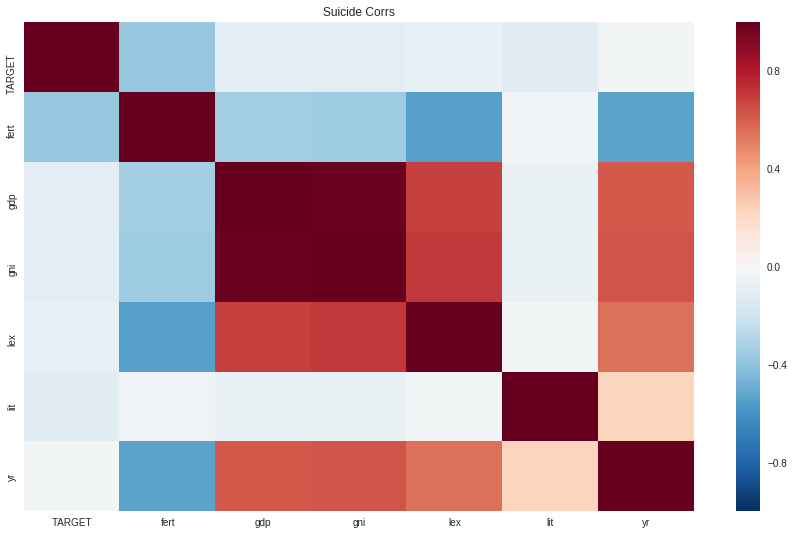

In [175]:
all_df = pd.DataFrame(all_data, columns=DV.feature_names_)
all_df = all_df[all_df['TARGET'] != 0.0]
corrs = all_df.corr()
sns.heatmap(corrs)
plt.title('Suicide Corrs')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d2d1457b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f8d2c3bd208>]], dtype=object)

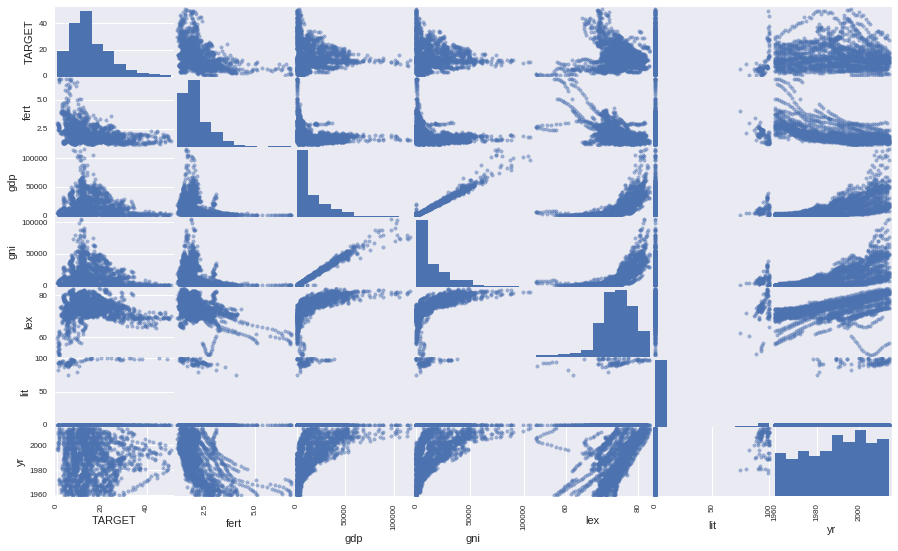

In [176]:
pd.tools.plotting.scatter_matrix(all_df)